# Criação de modelo baseline p/ identificação de discurso de ódio

[Voltar ao Índice](../00_indice.ipynb)

Vamos criar um modelo de identificação básico, bag of words, para servir de referência para a performance obtida com o BERT pré-treinado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xavy.explore as xe
import xavy.dataframes as xd
import xavy.utils as xu
import xavy.text as xt
import xavy.mltools as ml

## Funções

In [2]:
def read_offcombr(path):
    """
    Load an ARFF file from OffComBR project 
    by reading it as a CSV file. The CSV 
    parameters are tuned and hard-coded for
    the project's data.

    Returns a DataFrame
    """
    df = pd.read_csv(path, skiprows=8, names=['label','sentence'], quotechar="'")
    return df

## Carregando os dados

Fontes: <https://github.com/paulafortuna/Portuguese-Hate-Speech-Dataset> e <https://github.com/rogersdepelle/OffComBR>

In [3]:
# Carrega dados da Paula Fortuna:
binhate_df = pd.read_csv('../../dados/brutos/Portuguese-Hate-Speech-Dataset/2019-05-28_portuguese_hate_speech_binary_classification.csv')

In [4]:
# Construindo base mais rigorosa:

annotations = ['hatespeech_G1', 'hatespeech_G2', 'hatespeech_G3']

assert binhate_df.query('hatespeech_comb == 0')[annotations].sum(axis=1).max() == 1
binhate_df.loc[binhate_df['hatespeech_comb'] == 0, 'label'] = 0
binhate_df.loc[binhate_df[annotations].sum(axis=1) > 2.5, 'label'] = 1

xclass_df = binhate_df.loc[~binhate_df['label'].isnull()].copy()
xclass_df['label'] = xclass_df['label'].astype(int)
xclass_df = xclass_df[['label', 'text']]

In [5]:
# Carrega dados do Pelle:
offcombr_df = read_offcombr('../../dados/brutos/OffComBR/OffComBR2.arff')
offcombr_df.rename({'sentence':'text'}, axis=1, inplace=True)
offcombr_df['label'] = offcombr_df['label'].map({'yes':1, 'no':0})

In [6]:
# Junta as bases:
mass_df = pd.concat([xclass_df, offcombr_df], ignore_index=True)

In [7]:
# Salva resultado:
#mass_df.to_csv('../../dados/processados/hatespeech_fortuna3+offcombr2.csv', index=False)

### Separando em amostras

In [8]:
# Seleciona a base de dados:
#data_df = binhate_df
data_df = mass_df
X_col = 'text'
#y_col = 'hatespeech_comb'
y_col = 'label'

# Divide em treino e teste:
train_df, test_df = ml.random_set_split(data_df, [0.8, 0.20], 876409)
X_train, y_train = ml.Xy_split(train_df[[X_col, y_col]], y_col)
X_train = X_train[X_col]
X_test,  y_test  = ml.Xy_split(test_df[[X_col, y_col]], y_col)
X_test  = X_test[X_col]

## Modelo de chute aleatório

Como ponto zero de performance, vamos utilizar um "modelo" que chuta qualquer categoria de maneira aleatória.

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from xavy.mltools import geomean_hit_rate

In [10]:
random_model = ml.RandomPicker()
random_model.fit(X_train, y_train)
y_test_pred = random_model.predict(X_test)

scorers = {'acc': accuracy_score, 'f1': f1_score, 'prec':precision_score, 'rec': recall_score, 'ghr': geomean_hit_rate}
for k, v, in scorers.items():
    x = v(y_test, y_test_pred)
    print('{}: {:.3f}'.format(k, x))

acc: 0.504
f1: 0.242
prec: 0.161
rec: 0.481
ghr: 0.495


## Treinando o modelo

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Construindo o modelo

In [12]:
stopwords = xt.return_pt_stopwords()

In [13]:
vec = CountVectorizer(lowercase=True, stop_words=stopwords, ngram_range=(1,1), max_df=1.0, min_df=2, binary=False)
#fit1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features='sqrt', n_jobs=1, class_weight={1:2.5,0:1})
#fit2 = LogisticRegression(C=0.6, max_iter=10000)
#fit3 = SVC(kernel='rbf', C=3)
#fit4 = SVC(kernel='sigmoid', C=3)
#fit5 = MultinomialNB(alpha=3)
fit1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features='sqrt', n_jobs=1, class_weight={1:1.5,0:1})
fit2 = LogisticRegression(C=3.0, max_iter=10000)
fit3 = SVC(kernel='rbf', C=3)
fit4 = SVC(kernel='sigmoid', C=6)
fit5 = MultinomialNB(alpha=0.1)
fit = VotingClassifier([('rf', fit1), ('lr', fit2), ('rbf', fit3), ('sig', fit4), ('nb', fit5)], weights=[0.34749828, 0.20278123, 0.36855106, 0.0751048 , 0.00606463])
model = Pipeline([('vec', vec), ('fit', fit)])

#### Grid search p/ os modelos constituintes

In [14]:
def fit_n_plot_grid(vec, fit, param_grid, X_train, y_train):
    
    model = Pipeline([('vec', vec), ('fit', fit)])
    grid  = GridSearchCV(model, param_grid, scoring='f1', n_jobs=6, refit=False, return_train_score=True)
    dump  = grid.fit(X_train, y_train)
    ml.plot_pars_scores(grid)

/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


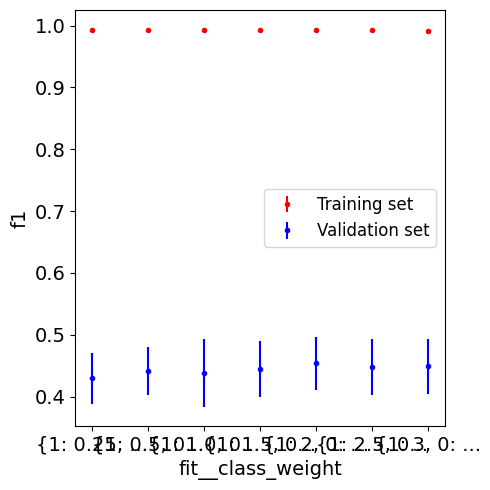

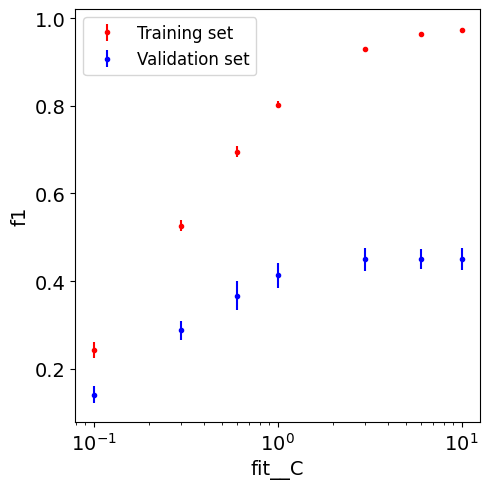

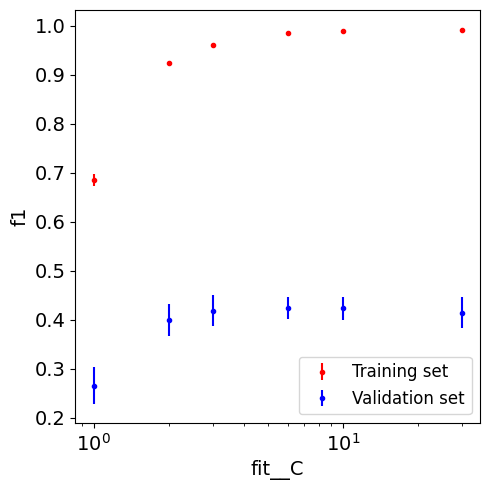

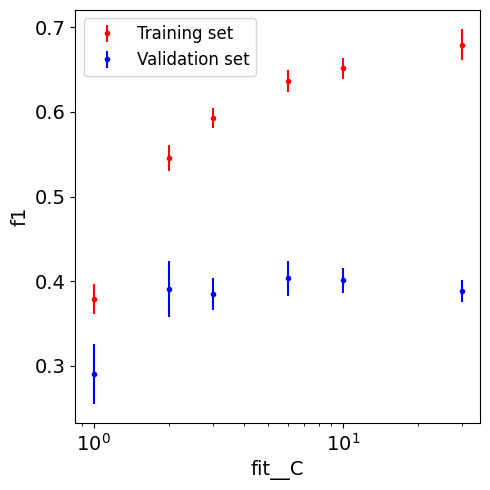

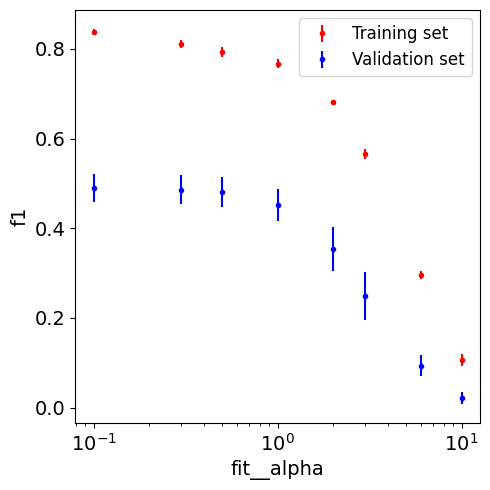

In [15]:
fitters = [fit1, fit2, fit3, fit4, fit5]
params  = [{'fit__class_weight': [{1:0.25, 0:1}, {1:0.5, 0:1}, {1:1.0, 0:1}, {1:1.5, 0:1}, {1:2,0:1}, {1:2.5,0:1}, {1:3,0:1}]}, 
           {'fit__C': [0.1, 0.3, 0.6, 1.0, 3.0, 6.0, 10.]},
           {'fit__C': [1.0, 2.0, 3.0, 6.0, 10., 30.]},
           {'fit__C': [1.0, 2.0, 3.0, 6.0, 10., 30.]},
           {'fit__alpha': [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 6.0, 10.]}]
for f, p in zip(fitters, params):
    fit_n_plot_grid(vec, f, p, X_train, y_train)

#### Processo iterativo de definição dos pesos dos votos

In [16]:
#vote_weights = [np.random.rand(4) * 2 for _ in range(40)]
expected_weights = np.array([0.35721117, 0.19877604, 0.36376866, 0.07514268, 0.00510145])
vote_weights = [np.random.normal(loc=expected_weights, scale=expected_weights/7) for _ in range(10)]

In [17]:
param_grid = {#'vec__lowercase': [True, False],
              #'vec__ngram_range': [(1,1), (1,2)],
              #'vec__min_df': [1, 2, 4],
              #'vec__binary': [True, False],
              #'vec__stop_words': [None, stopwords],
              #'fit__alpha': [ 1, 3., 10],
              #'fit__fit_prior':[True, False],
              #'fit__kernel':['poly', 'rbf', 'sigmoid'],
              #'fit__degree':[1,2,3],
              #'fit__gamma': [0.03, 0.06, 0.10],
              #'fit__coef0': [0, 0.3, 1.0],
              #'fit__C': [1.0, 3.0, 10.],
              'fit__weights':vote_weights
              #'fit__max_depth': [6, 12, 20, 30, 60, 120], 
              #'fit__min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16], 
              #'fit__class_weight': [{1:1,0:1}, {1:1.7,0:1}, {1:2,0:1}, {1:2.5,0:1}]
}
grid = GridSearchCV(model, param_grid, scoring='f1', n_jobs=6, refit=False, return_train_score=True)

In [18]:
dump = grid.fit(X_train, y_train)

In [19]:
opt_df = ml.searchCV_table(grid)
opt_sorted_weights = opt_df['param_fit__weights']
opt_sorted_weights = opt_sorted_weights / opt_sorted_weights.apply(np.sum)
opt_sorted_weights.iloc[0]

array([0.42299091, 0.16591474, 0.31976993, 0.08531752, 0.0060069 ])

In [20]:
opt_df.head()

,mean_fit_time,std_fit_time,param_fit__weights,mean_test_score,std_test_score,mean_train_score,std_train_score
0,3.035900,0.300763,"[0.38798954556548537, 0.15218573433437682, 0.2...",0.457468,0.042369,0.964417,0.003203
3,3.073945,0.426383,"[0.3827116877538412, 0.1704470840220361, 0.412...",0.455975,0.029619,0.962968,0.004226
9,2.816962,0.236165,"[0.3145408620217274, 0.20586663644881592, 0.36...",0.455436,0.031267,0.962968,0.004226
6,3.157055,0.451573,"[0.3790963723585427, 0.19873440888089194, 0.30...",0.454114,0.031952,0.962968,0.004226
8,3.319593,0.273416,"[0.3900353120136976, 0.1926404592318421, 0.376...",0.453922,0.033133,0.962968,0.004226


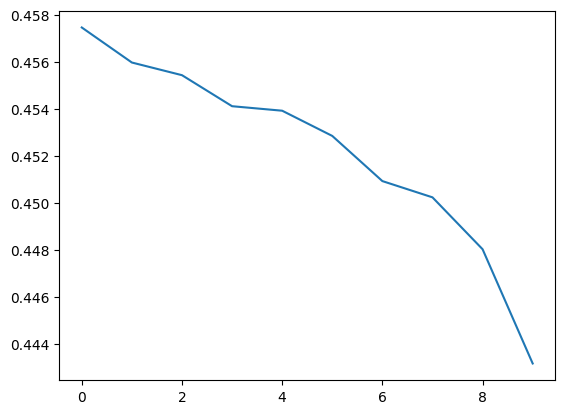

In [21]:
pl.plot(opt_df['mean_test_score'].iloc[:35].values)
pl.show()

#### Avaliação do  modelo

In [22]:
np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy'))

0.8641078150437197

In [23]:
np.mean(cross_val_score(model, X_train, y_train, scoring='f1'))

0.45077795509134927

In [59]:
np.mean(cross_val_score(model, X_train, y_train, scoring='precision'))

0.6777159139982099

In [60]:
np.mean(cross_val_score(model, X_train, y_train, scoring='recall'))

0.3386631598040994

## Learning curve

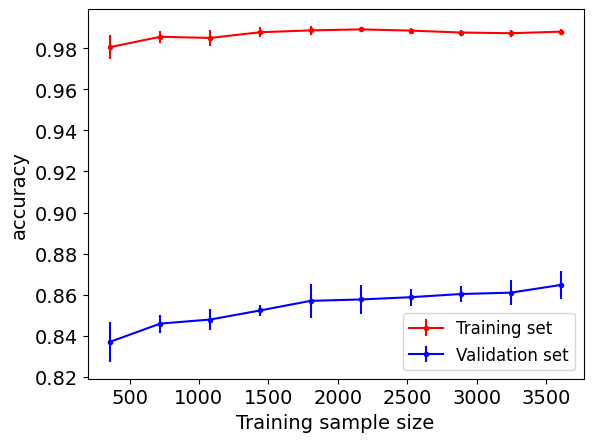

In [24]:
ml.plot_learning_curve(model, X_train, y_train, 'accuracy')
pl.show()

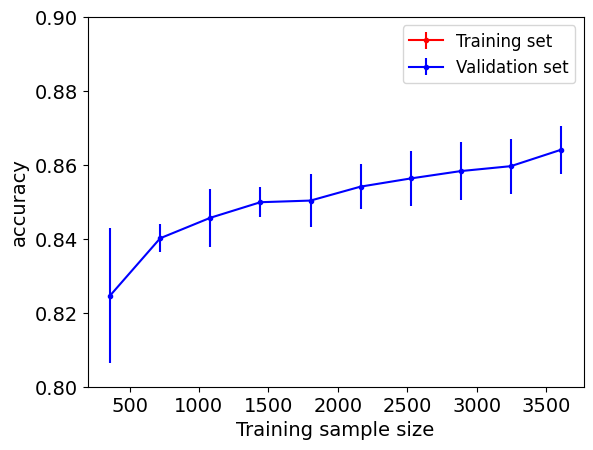

In [25]:
ml.plot_learning_curve(model, X_train, y_train, 'accuracy')
#pl.ylim([0.7, 0.8])
pl.ylim([0.8, 0.9])
pl.show()

### Avaliação na amostra de teste

In [26]:
dump = model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.87322695035461

In [17]:
confusion_matrix(y_test, y_test_pred)

array([[916,  27],
       [121,  64]])

In [21]:
scorers = {'acc': accuracy_score, 'f1': f1_score, 'prec':precision_score, 'rec': recall_score, 'gmr': geomean_hit_rate}
for k, v, in scorers.items():
    x = v(y_test, y_test_pred)
    print('{}: {:.3f}'.format(k, x))

acc: 0.870
f1: 0.469
prec: 0.707
rec: 0.351
gmr: 0.584


**Resultados**

* A avaliação na amostra de teste para os dados binários da Paula Fortuna (exemplos selecionados com dois dos três anotadores concordando):
    * Accuracy: 0.75
    * F1: 0.51
* A avaliação na amostra de teste para os dados combinados de Paula e Pelle:
    * Accuracy: 0.87
    * F1: 0.47

## Explorando dados utilizados na construção do modelo

In [27]:
xd.print_string_series(mass_df.loc[mass_df['label'] == 1, 'text'].sample(10))

5239: E O PIAUI QUERENDO ASSUSTAR O MUNDO COM ESTA FIGURA OU SO NASCE GENTE FEIA LA
1154: @Estadao @CamilaPitanga estou com @RachelSherazade. são idiotas inúteis, mamadores do dinheiro público, iludem milhões de imbecis.
2420: OLGA BENARIO
Vai toma no cu https://t.co/ux61TtGZLh
3316: RT @gabrielasoligo: Hj é mulher maravilhosa, mulher é isso e aquilo..amanhã é pq mulher é tudo burra, N pode dirigir, lugar de mulher é no _
5406: Sao paulinos gostam de mamar no cajado
1383: @filhadolula eu lutei mas ai ela raspou a cabeça e ta mto sapatão isso ta acabando cmg...........
1308: farta de procurar trabalho, ainda me meto mas é a trabalhar num bar de fufas, mais vale
4779: Cruz credo dessa bosta
3104: RT @becsamorim: eu queria dedicar esse tweet à minha sapatonice
obrigada vida por ser sapatão
bjs
5249: Boca de sapo


In [28]:
xd.print_string_series(mass_df['text'].sample(10))

3676: RT @pintomondim: A PSP interceptou o q julgavam ser um automóvel sem condutor em excesso de velocidade,apurou-se mais tarde q ao volante ia _
2917: Quero ver quando for p vir de branco nos dias de clínica, não quero
3643: RT @PanichiRaphael: Lembrem-se FemiNazis:
No Oriente Médio e no mundo muçulmano onde reina a Sharia não houve dia internacional da Mulher _
1235: É um absurdo certos tipos de Cultura. Uma criança pode casar. Mas são obrigadas a usar burca e algumas não... https://t.co/zMxDAu98LH
2651: @pefabiodemelo Ta falando do Felipe neto @felipeneto
4208: UMA GERAÇÃO DE JOVENS QUE AO INVÉS DE ESTAR BEBENDO, BRIGANDO, JOGANDO BOLA E VENDO MULHER PELADA...
PASSA O SÁBADO NO CBLOL
7X1 FOI POUCO
2027: Meninas tem q ser ensinadas q sentimentalismo é merda, a Disney é golpista (não existe príncipe) e cavalheirismo é frescura no rabo
2277: @NetMane olhe que não. Eles sofrem metamorfoses e regressam sempre no dia seguinte escondidos num ovo.
617: cara, ao invés de clamar pelo Criado